https://adventuresinmachinelearning.com/neural-networks-tutorial/

(1797, 64)


<Figure size 432x288 with 0 Axes>

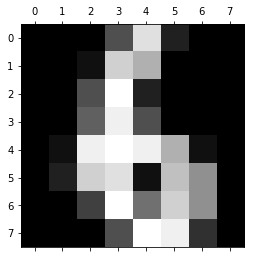

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[34])
plt.show()

### scale the data

In [22]:
digits.data[0,:]


array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [23]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X[0,:]


array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

### train test split

In [25]:
from sklearn.model_selection import train_test_split
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## setting up the output layer
A sensible neural network architecture would be to have an output layer of 10 nodes. Each representing a digit from 0 to 9.

For the minst data supplied in the scikit learn dataset the targes are in the form of a single number, we need to convert them to vecotrs so that it lines up with our 10 node output layer. 

In [30]:
import numpy as np
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] =1
    return y_vect
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

y_train[0], y_v_train[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

## Creating the neural network

This step specifies the structure of the neural network. For the input layer, we know we need 64 nodes to cover the 64 pixels in the image. As discussed we need 10 output layer nodes to predict the digits. We'll also need a hidden layer in our network to allow for the complexity of the task. Usually the number of hidden layer nodes is somewhere between the number of inupt layers and the number of output layers. 

We define a python list that designates the structure of our network. 

In [61]:
nn_structure = [64, 30, 10]

we use sigmoid activation functions, so we setup the sigmoid function and it's derivative:

In [53]:
def f(x):
    return 1 / (1 + np.exp(-x))
def f_deriv(x):
    return f(x) * (1 - f(x))

# Training algorithem
Randomly initialise the weights for each layer $W^{(l)}$

while iterations < iteration limit:
1. set $\Delta W$ and $\Delta b$ to zero
2. for samples 1 to m:

    a. perform a feed forward pass though all the $n_l$ layers. Store the activation function outputs $h^{(l)}$
    
    b. calculate $\delta^{(n_l)}$ value for the output layer
    
    c. use backpropagation to calculate the $\delta^{(l)}$ values for layers 2 to $n_l-1$
    
    d. update the $\Delta W^{(l)}$ and $\Delta b^{(l)}$ for each layer


3. perform a gradient descent step using
$$
W^{(l)} = W^{(l)} - \alpha\bigg[ \frac{1}{m} \Delta W^{(l)} \bigg]
$$
$$
b^{(l)} = b^{(l)} - \alpha\bigg[ \frac{1}{m} \Delta b^{(l)} \bigg]
$$

### initialise the weights for each layer

the weights have to be initialised with random values, this is to ensure that the neural network will converge correctly during training. we use the random_sample function from the numpy library

In [54]:
import numpy.random as r
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [55]:
r.random_sample((5,))

array([0.29139369, 0.5199788 , 0.32688666, 0.16132765, 0.0981076 ])

the next step is to set the mean accumulation values $\Delta W$ and $\Delta b$ to zero. (They need to be the same size as the weight and bias matrices.)

In [65]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

### gradient descent
we now step into the gradient descent loop

In [57]:
def feed_forward(x, W, b):
    h = {1:x}
    z = {}
    for l in range(1, len(W)+1):
        # if it's the first layer than the input into the weights is x, otherwise,
        # it's the output fromt he last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l))
    return h, z

In [58]:
def calculate_out_layer_delta(y, h_out, z_out):
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

### training the network (function)

In [68]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    count = 0
    m = len(y)
    avg_cost_func = []
    print("starting gradient descent for {} iterations".format(iter_num))
    while count < iter_num:
        if count%1000 == 0:
            print('Iteration {} of {}'.format(count, iter_num)) # trace
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, 
            # to be used in the gradient descent step
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagation the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i, :], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l>1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:, np.newaxis], np.transpose(h[l][:,np.newaxis]))
                    # trib^l(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
                    
        # perform the gradient descent step for the weights in each 
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        count +=1
    return W, b, avg_cost_func

Here the termination of the gradient descent process is a set number of iterations, it is not based on how well the network is performing.

In [69]:
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train)

starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


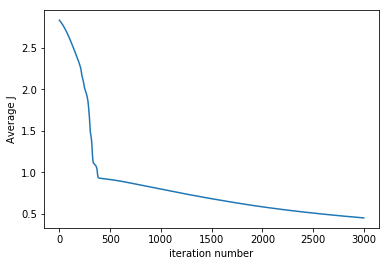

In [70]:
plt.plot(avg_cost_func)
plt.ylabel("Average J")
plt.xlabel("iteration number")
plt.show()